In [54]:
import torch
import numpy as np
from torchvision import datasets, transforms
from siren import Sine

In [2]:
batch_size = 1
transform=transforms.ToTensor()
dataset_train = datasets.MNIST('data', train=True, download=True,transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

In [3]:
im, label = next(iter(dataloader_train))
im = im - 0.5

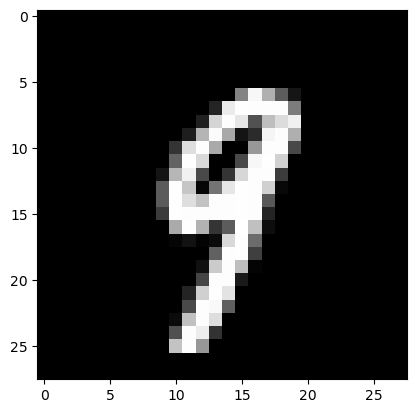

In [4]:
# plot image using maplotlib
import matplotlib.pyplot as plt
plt.imshow(im[0,0], cmap='gray')
plt.show()

In [5]:
class coordx_net(torch.nn.Module):
    def __init__(self, channels):
        super(coordx_net, self).__init__()
        self.channels=channels
        self.x_first = torch.nn.Linear(1,64)
        self.y_first = torch.nn.Linear(1,64)
        self.premerge_parallels = torch.nn.Sequential(
            Sine(),
            torch.nn.Linear(64,64),
            Sine(),
            torch.nn.Linear(64,64),
            Sine()
        )
        
        self.postmerge = torch.nn.Sequential(
            torch.nn.Linear(64,32),
            Sine(),
            torch.nn.Linear(32,self.channels),
            torch.nn.Sigmoid()
        )
    
    def merge(self,x,y):
        return torch.einsum("ik,jk->ijk",x,y)

    def forward(self, x, y):
        x1 = self.x_first(x)
        y1 = self.y_first(y)
        x2 = self.premerge_parallels(x1)
        y2 = self.premerge_parallels(y1)
        merged = self.merge(x2,y2)
        res = self.postmerge(merged)
        # reshape to (channels, x, y)
        res = res.permute(2,0,1)
        return res

In [6]:
x = torch.linspace(1, 28, 28).reshape(28,1)
y = torch.linspace(1, 28, 28).reshape(28,1)

In [7]:
net = coordx_net(channels=1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [8]:
for epoch in range(5000):
    optimizer.zero_grad()
    out = net(x,y)
    loss = loss_fn(out, im[0])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Iteration: {epoch} | Loss: {loss.item()}')

Iteration: 0 | Loss: 0.777158260345459
Iteration: 10 | Loss: 0.7176668047904968
Iteration: 20 | Loss: 0.5602462291717529
Iteration: 30 | Loss: 0.3151985704898834
Iteration: 40 | Loss: 0.2509743571281433
Iteration: 50 | Loss: 0.24755047261714935
Iteration: 60 | Loss: 0.2437039464712143
Iteration: 70 | Loss: 0.24180306494235992
Iteration: 80 | Loss: 0.24063818156719208
Iteration: 90 | Loss: 0.2398780733346939
Iteration: 100 | Loss: 0.23929697275161743
Iteration: 110 | Loss: 0.23881061375141144
Iteration: 120 | Loss: 0.2383936643600464
Iteration: 130 | Loss: 0.23802565038204193
Iteration: 140 | Loss: 0.2376922369003296
Iteration: 150 | Loss: 0.23737366497516632
Iteration: 160 | Loss: 0.23697613179683685
Iteration: 170 | Loss: 0.2352319210767746
Iteration: 180 | Loss: 0.23426233232021332
Iteration: 190 | Loss: 0.23342537879943848
Iteration: 200 | Loss: 0.2325998991727829
Iteration: 210 | Loss: 0.23191848397254944
Iteration: 220 | Loss: 0.23141728341579437
Iteration: 230 | Loss: 0.231042012

In [9]:
merged = net(x,y)
loss_fn(merged, im[0])

tensor(0.2152, grad_fn=<MseLossBackward0>)

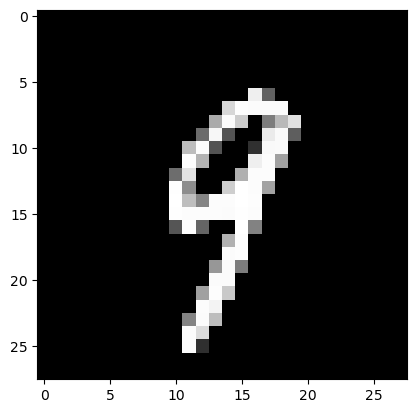

In [10]:
# plot the output of the network
plt.imshow(merged[0,:,:].detach().numpy(), cmap='gray')
plt.show()

In [21]:
# try with R value network
class coordx_net(torch.nn.Module):
    def __init__(self, r, channels, hidden = 64):
        super().__init__()
        self.R = r
        self.channels =  channels
        print(f"R: {r}, Hidden Layers: {hidden}, Channels: {channels}")
        premerge_hidden = hidden * self.R

        self.x_first = torch.nn.Linear(1, premerge_hidden)
        self.y_first = torch.nn.Linear(1, premerge_hidden)
        self.premerge_parallels = torch.nn.Sequential(
            Sine(),
            torch.nn.Linear(premerge_hidden, premerge_hidden),
            Sine(),
            torch.nn.Linear(premerge_hidden, premerge_hidden),
            Sine()
        )
        
        self.postmerge = torch.nn.Sequential(
            torch.nn.Linear(hidden, hidden),
            Sine(),
            torch.nn.Linear(hidden, self.channels),
            torch.nn.Sigmoid()
        )
    
    def merge(self,x,y):
        x3 = torch.einsum("ijk->ik", x)
        y3 = torch.einsum("ijk->ik", y)
        return torch.einsum("ik,jk->ijk", x3, y3)

    def forward(self, x, y):
        x1 = self.x_first(x)
        y1 = self.y_first(y)
        x2 = self.premerge_parallels(x1)
        y2 = self.premerge_parallels(y1)
        x2 = x2.reshape((x2.shape[0], self.R, int(x2.shape[1]/self.R)))
        y2 = y2.reshape((y2.shape[0], self.R, int(y2.shape[1]/self.R)))
        merged = self.merge(x2,y2)
        res = self.postmerge(merged)
        return res
    

In [57]:
net = coordx_net(r=2, channels=1, hidden=1)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

R: 2, Hidden Layers: 1, Channels: 1


In [58]:
for epoch in range(1000):
    optimizer.zero_grad()
    out = net(x,y)
    loss = loss_fn(out, im[0])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Iteration: {epoch} | Loss: {loss.item()}')

c:\ProgramData\miniconda3\envs\eecs6322-a1\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([28, 28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration: 0 | Loss: 1.0139639377593994
Iteration: 10 | Loss: 1.0029690265655518
Iteration: 20 | Loss: 0.9925239682197571
Iteration: 30 | Loss: 0.9825714230537415
Iteration: 40 | Loss: 0.9730228781700134
Iteration: 50 | Loss: 0.9637886881828308
Iteration: 60 | Loss: 0.9547956585884094
Iteration: 70 | Loss: 0.9459881782531738
Iteration: 80 | Loss: 0.9373189210891724
Iteration: 90 | Loss: 0.928737998008728
Iteration: 100 | Loss: 0.9201739430427551
Iteration: 110 | Loss: 0.9114878177642822
Iteration: 120 | Loss: 0.9023966789245605
Iteration: 130 | Loss: 0.8925483226776123
Iteration: 140 | Loss: 0.8816161751747131
Iteration: 150 | Loss: 0.8694024682044983
Iteration: 160 | Loss: 0.855820894241333
Iteration: 170 | Loss: 0.8409371376037598
Iteration: 180 | Loss: 0.8249135613441467
Iteration: 190 | Loss: 0.8078742027282715
Iteration: 200 | Loss: 0.7900593280792236
Iteration: 210 | Loss: 0.7716482877731323
Iteration: 220 | Loss: 0.7527994513511658
Iteration: 230 | Loss: 0.7336297035217285
Itera

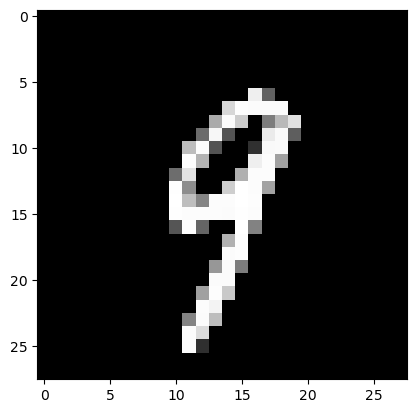

In [53]:
# plot the output of the network
plt.imshow(merged[0,:,:].detach().numpy(), cmap='gray')
plt.show()
#hidden 64
hidden_64 = merged[0,:,:].detach().numpy()
#Loss: 0.23366601765155792

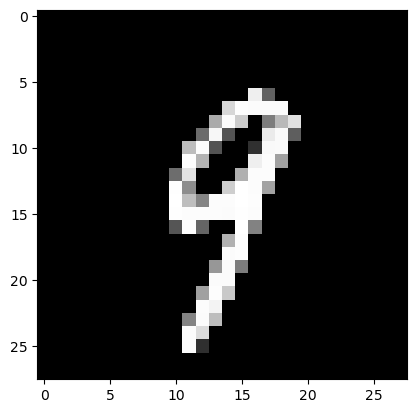

In [59]:
# plot the output of the network
plt.imshow(merged[0,:,:].detach().numpy(), cmap='gray')
plt.show()
#hidden 1
hidden_1 = merged[0,:,:].detach().numpy()
#Loss: 0.34584513306617737

In [60]:
hidden_1 - hidden_64

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0